## Часть 1. Проверка гипотезы в Python и составление аналитической записки

- Автор: Сакович Мария
- Дата: 08.12.2025

## Цели и задачи проекта

1) Проверить гипотезу о том, что пользователи из Санкт-Петербурга проводят больше времени в сервисе Яндекс.Книги за чтением или прослушиванием книг, чем пользователи из Москвы. 
2) Провести оценку результатов A/B-теста по изменению интерфейса интернет-магазина BitMotion Kit

## Описание данных

С помощью SQL отобраны пользователи из Москвы и Санкт-Петербурга и рассчитана их активность, то есть сумма часов:

- city — город пользователя;

- puid — идентификатор пользователя;

- hours — общее количество часов активности.

## Содержимое проекта

Часть 1: Проверка гипотезы для Яндекс.Книги

1.1. Загрузка и предобработка данных

1.2. Проверка гипотезы

1.3. Интерпретация результатов

Часть 2: Анализ A/B-теста для BitMotion Kit

2.1. Цели исследования

2.2. Загрузка и предобработка данных

2.3. Проверка корректности проведения теста

2.4. Подготовка данных для анализа конверсии

2.5. Расчет ключевых метрик

2.6. Статистический анализ результатов

2.7. Формирование выводов и рекомендаций


---

## 1. Загрузка данных и знакомство с ними


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize


Загрузим данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) 

In [ ]:
df=pd.read_csv("yandex_knigi_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


In [4]:
df.head()

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


<div class="alert alert-warning">
    <h2> Ревьюер Евгения <a class="tocSkip"> </h2>
    
⚠️ Рекомендую удалить столбец `Unnamed: 0`. Он полностью дублирует индексы.
        
---

Комментарий студента:  Он уже удален - см. следующую ячейку кода.

Датасет состоит из 8784 строк и 4 столбцов. При этом один из столбцов дублирует индекс. Типы данных и содержание соответствуют описанию. Пропуски отсутствуют.

In [5]:
# Исходная версия
##Удалим лишний столбец
# df=df[['city','puid','hours']]

#Вспомнила более удачный способ
#Удалим лишний столбец
df = df.drop('Unnamed: 0', axis=1)

<div class="alert alert-success">
<h2> Ревьюер Евгения v3<a class="tocSkip"> </h2>

✅ +

Проверим наличие дубликатов в идентификаторах пользователей.

In [6]:
df['puid'].duplicated().sum()

244

In [7]:
df[df['puid'].duplicated(keep=False)].sort_values(by='puid')

,city,puid,hours
35,Москва,2637041,10.317371
6247,Санкт-Петербург,2637041,3.883926
134,Москва,9979490,32.415573
6274,Санкт-Петербург,9979490,1.302997
145,Москва,10597984,42.931506
...,...,...,...
6195,Москва,1130000020425037,0.310556
8775,Санкт-Петербург,1130000023864516,14.384722
6202,Москва,1130000023864516,142.830085
6210,Москва,1130000028554332,11.277554


Похоже, что все или часть найденных дубликатов объясняются тем, что некоторые пользователи открывали приложение в обоих городах. Проверим дубликаты по сочетанию города и идентификатора пользователя.

In [8]:
df.duplicated(subset=['city','puid']).sum()

0

Действительно, все повторяющиеся значения в столбце puid - это пользователи, которые заходили в приложение и в Москве, и в Санкт-Петербурге. 

<div class="alert alert-block alert-danger">
<h2> Ревьюер Евгения <a class="tocSkip"></h2>

❌ Необходимо избавиться от них. Для корректного проведения теста, выборки должны быть независимыми.

---

Комментарий студента:

<div class="alert alert-block alert-danger">
<h2> Ревьюер Евгения v2<a class="tocSkip"></h2>

❌ Дубликаты по puid не удалены. 

---

Комментарий студента: добавила ниже

Для выполнения условия о независимости выборок удалим этих пользователей. 

In [9]:
df.drop_duplicates('puid',keep=False, inplace=True)

In [10]:
df['puid'].duplicated().sum()

0

<div class="alert alert-success">
<h2> Ревьюер Евгения v3<a class="tocSkip"> </h2>

✅ +

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуем статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

<div class="alert alert-success">
<h2> Ревьюер Евгения <a class="tocSkip"> </h2>

✅ Супер, гипотезы сформулированы!
    
---

Комментарий студента: 

In [11]:
msk_hours=df[df['city']=='Москва']['hours']
spb_hours=df[df['city']=='Санкт-Петербург']['hours']


In [12]:
print(f'Москва: Среднее количество часов - {round(msk_hours.mean(),2)}, стандартное отклонение {msk_hours.std():.2f}')
print(f'Санкт-Петербург: Среднее количество часов - {round(spb_hours.mean(),2)}, стандартное отклонение {spb_hours.std():.2f}')

Москва: Среднее количество часов - 10.85, стандартное отклонение 36.93
Санкт-Петербург: Среднее количество часов - 11.26, стандартное отклонение 39.83


Проверим распределения данных по Москве и СПб. 

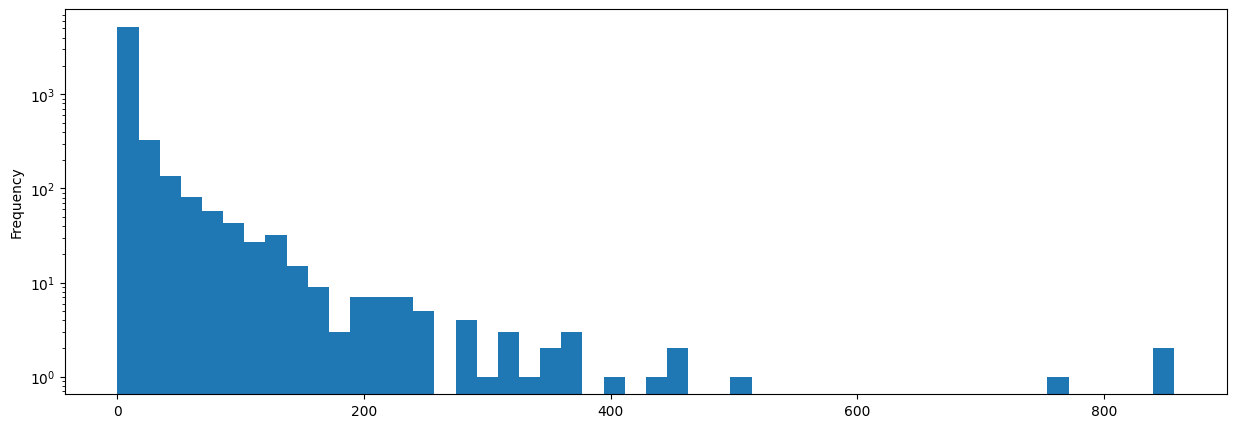

Text(0.5, 1.0, 'Распределение активности в Москве (log scale)')

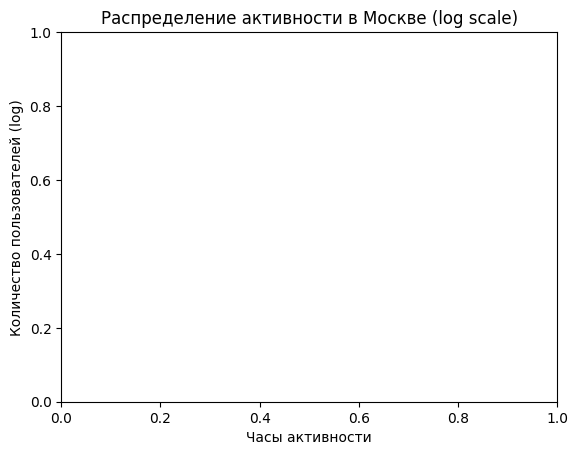

In [13]:
msk_hours.plot(
    kind='hist',
    bins=50,
    figsize=(15,5),
    logy=True
)
plt.show()
plt.xlabel('Часы активности')
plt.ylabel('Количество пользователей (log)')
plt.title('Распределение активности в Москве (log scale)')

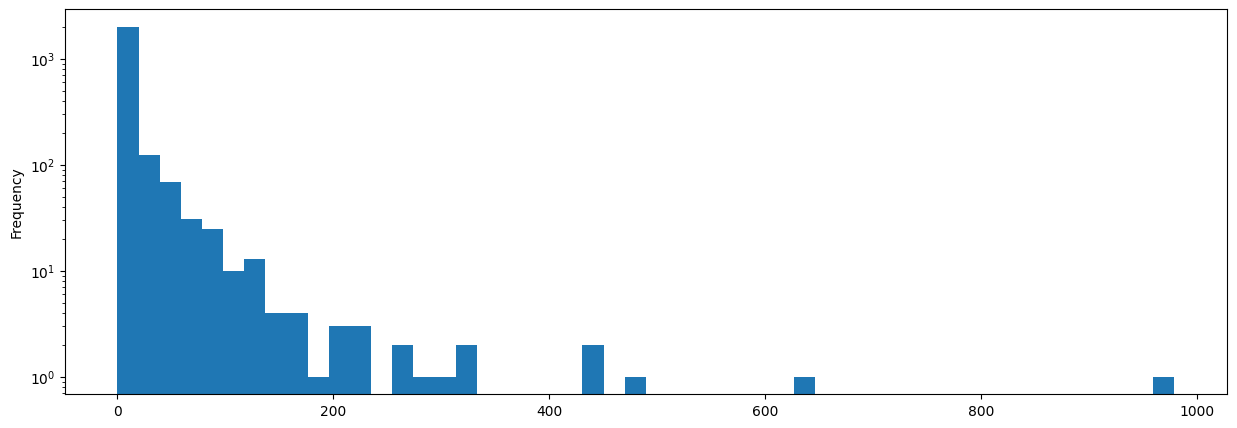

Text(0.5, 1.0, 'Распределение активности в Санкт-Петербурге (log scale)')

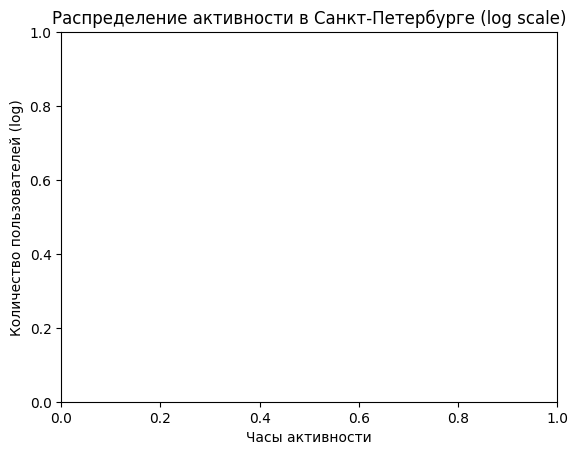

In [14]:
spb_hours.plot(
    kind='hist',
    bins=50,
    figsize=(15,5),
    logy=True
)
plt.show()
plt.xlabel('Часы активности')
plt.ylabel('Количество пользователей (log)')
plt.title('Распределение активности в Санкт-Петербурге (log scale)')

Распределения не являются нормальными, поэтому Т-тест Уэлча не подойдет для проверки гипотезы. Воспользуемся тестом Манна-Уитни.

<div class="alert alert-success">
<h2> Ревьюер Евгения <a class="tocSkip"> </h2>

✅ Есть сравнение размера выборок и их статистик. 
    
---

Комментарий студента: 

In [15]:
alpha = 0.05
stat_mw, p_value_mw = mannwhitneyu(
    spb_hours, 
    msk_hours, 
    alternative='greater' )


if p_value_mw <alpha:
    print(f"p_value_mw={round(p_value_mw,6)}<{alpha}. Отвергаем H₀: Средняя активность в СПб статистически значимо больше, чем в Москве")
else:
    print(f"p_value_mw={round(p_value_mw,6)}>{alpha}.Не отвергаем H₀: Нет статистически значимых различий в активности")

p_value_mw=0.453227>0.05.Не отвергаем H₀: Нет статистически значимых различий в активности


<div class="alert alert-success">
<h2> Ревьюер Евгения <a class="tocSkip"> </h2>

✅  Тест выполнен корректно.
    
---

Комментарий студента: 

## 3. Аналитическая записка

Для проверки статистической значимости был выбран тест Манна-Уитни, поскольку распределения не нормальные, уровень значимости 0.05 выбран как общепринятый стандарт в статистических исследованиях, представляющий разумный компромисс между риском ложного обнаружения различий (ошибка I рода) и вероятностью пропустить реальный эффект (ошибка II рода). 

На уровне значимости alpha = 0.05 нет статистически значимых доказательств того, что пользователи из Санкт-Петербурга проводят больше времени в приложении, чем пользователи из Москвы (p = 0.089).Хотя наблюдается тенденция к более высокой активности в Санкт-Петербурге, эта разница не достигает порога статистической значимости. Таким образом, исходная гипотеза о том, что пользователи из Санкт-Петербурга проводят больше времени в приложении, не нашла статистического подтверждения на текущей выборке данных.

Более высокое среднее значение продолжительности прослушивания пользователями из СПб может объясняться присутствием выбросов и их увеличенной долей по сравнению с Москвой. 

Разные размеры выборок (СПб: 2550, Москва: 6234) могли повлиять на мощность теста. Для обнаружения слабых эффектов может потребоваться больший объем данных.

<div class="alert alert-success">
<h2> Ревьюер Евгения <a class="tocSkip"> </h2>

✅  Аналитическая записка по результатам тестирования сформирована, наполнение соответствует заданию.
    
    
Тест Уэлча также обязательно проводить если размер выборок сильно отличается (если более чем 1 к 4 - обязательно). 
    
---

Комментарий студента: Комментарий студента: а разве можно его проводить, если у нас распределение далеко от нормального?... 

<div class="alert alert-success">
<h2> Ревьюер Евгения v3<a class="tocSkip"> </h2>

✅ Да, наоборот, в таком случае, именно этот тест и используем. 

----

# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## 1. Опишите цели исследования.



Проанализировать результаты А/В-тестирования для интернет-магазина BitMotion Kit для проверки, помогло ли обновление интерфейса онлайн-магазина увеличить количество пользователей, который совершат покупку. 

## 2. Загрузите данные, оцените их целостность.


In [16]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [17]:
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [18]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


Датасет participants содержит информацию об участниках тестов. Он состоит из 14525 строк и 4 столбцов, типы данных корректны, пропуски отсутствуют.

In [19]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [20]:
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


Датасет events содержит информацию об действиях пользователей в приложении за 2020 год. Он состоит из 787286 строк и 4 столбцов, типы данных корректны, пропуски присутствуют только в столбце details, в котором содержится дополнительная информация о событии - стоимость привлечения клиента или покупки (для event_name registration или purchase, соответственно), или регионы, в которых проводились промо-кампании.

In [21]:
events.event_name.unique()

array(['End of Black Friday Ads Campaign', 'registration', 'product_page',
       'login', 'product_cart', 'purchase',
       'Start of Christmas&New Year Promo',
       'Start of CIS New Year Gift Lottery'], dtype=object)

In [22]:
events[events['details'].isna()]['event_name'].unique()

array(['product_page', 'login', 'product_cart'], dtype=object)

Пропуски в датасете events присутствуют в столбце details и соответствуют значениям event_name: product_page, login, product_cart. Таким образом, наличие пропусков не мешает дальнейшему анализу. 

<div class="alert alert-success">
<h2> Ревьюер Евгения <a class="tocSkip"> </h2>

✅ Данные загружены. 
    
Согласна, пропуски можно оставить без изменений, а дубликаты обработать нужно. 
    
---

Комментарий студента:

<div class="alert alert-block alert-danger">
<h2> Ревьюер Евгения <a class="tocSkip"></h2>

❌ Маша, необходимо проверить дубликаты по событиям и удалить их при необходимости. 

---

Комментарий студента: добавила ниже  

In [23]:
events.duplicated().sum()

36318

In [24]:
events=events.drop_duplicates().reset_index(drop=True)


<div class="alert alert-success">
<h2> Ревьюер Евгения v3<a class="tocSkip"> </h2>

✅ Принято!

## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [25]:
#Выведем уникальные значения - названия тестов
participants.ab_test.unique()

array(['interface_eu_test', 'recommender_system_test'], dtype=object)

Таким образом, в таблице представлены 2 теста. Судя по названию, нам необходимо отфильтровать только interface_eu_test. 

In [26]:
interface_participants=participants[participants['ab_test']=='interface_eu_test'].reset_index(drop=True)
interface_participants

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,A,interface_eu_test,Android
2,001E72F50D1C48FA,A,interface_eu_test,Mac
3,002412F1EB3F6E38,B,interface_eu_test,Mac
4,002540BE89C930FB,B,interface_eu_test,Android
...,...,...,...,...
10845,FFE600EEC4BA7685,B,interface_eu_test,Android
10846,FFE7FC140521F5F6,A,interface_eu_test,PC
10847,FFEFC0E55C1CCD4F,A,interface_eu_test,PC
10848,FFF28D02B1EACBE1,B,interface_eu_test,PC


<div class="alert alert-success">
<h2> Ревьюер Евгения <a class="tocSkip"> </h2>

✅ Выделены участники исследуемого теста. Молодец, что выносишь их в отдельную переменную - исходные данные понадобятся для проверки пересечений между тестами.
    
---

Комментарий студента: 


In [27]:
#Рассчитаем количество уникальных пользователей по группам тестирования
interface_participants.groupby('group')['user_id'].nunique()

group
A    5383
B    5467
Name: user_id, dtype: int64

Общее количество пользователей в группах сопоставимо.

In [28]:
group_devices = (interface_participants.groupby(['group', 'device'])['user_id']
                 .count()
                 .reset_index(name='count'))
group_devices['total_per_group'] = group_devices.groupby('group')['count'].transform('sum')
group_devices['percentage'] = (group_devices['count'] / group_devices['total_per_group']) * 100
group_devices = group_devices.drop('total_per_group', axis=1)
pivot_df = group_devices.pivot(index='device', columns='group', values='percentage')
pivot_df


group,A,B
device,,
Android,45.420769,44.155844
Mac,10.514583,10.133528
PC,25.004644,25.937443
iPhone,19.060004,19.773185


<AxesSubplot:title={'center':'Распределение пользователей по устройствам в группах'}, xlabel='Тип устройства', ylabel='Доля пользователей'>

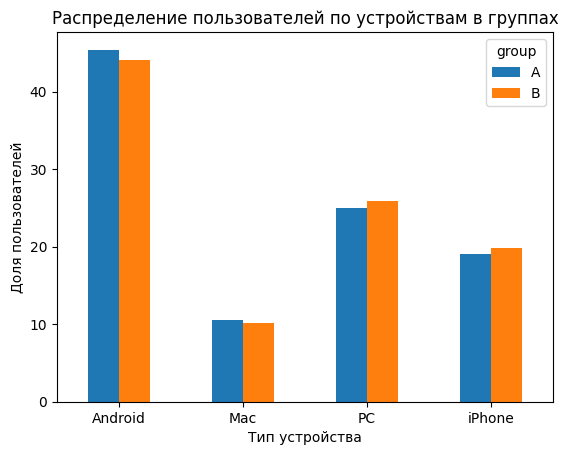

In [29]:
pivot_df.plot(
    kind='bar',
    rot=0,
    xlabel='Тип устройства',
    ylabel='Доля пользователей',
    title='Распределение пользователей по устройствам в группах'
)

Распределение пользователей по типам устройств в группах приблизительно одинаковое. 

<div class="alert alert-success">
<h2> Ревьюер Евгения <a class="tocSkip"> </h2>

✅ Распределение пользователей по группам и устройствам равномерное, верно.
    
---

Комментарий студента: 


In [30]:
(interface_participants.groupby('user_id')['group'].nunique()>1).sum()

0

Отсутствуют пользователи, для которых в столбце group указано более одного уникального значения - следовательно, отсутствуют пользователи, попавшие сразу в обе группы. 

<div class="alert alert-success">
<h2> Ревьюер Евгения <a class="tocSkip"> </h2>

✅ Хорошо, внутри исследуемого теста нет пересечений пользователей между группами.
    
---

Комментарий студента: 

<div class="alert alert-block alert-danger">
<h2> Ревьюер Евгения <a class="tocSkip"></h2>

❌ Так как в данных представлены результаты двух тестов, следует убедиться, что нет пользователей, попавших в оба теста сразу. В частности, нас интересует, есть ли пользователи, попавшие в группу В в двух тестах сразу. Если такие пользователи будут, по ним мы не сможем оценить эффект от нововведения, так как не сможем понять, под воздействием какого нововведения было совершено целевое событие - от изменений в нашем тесте или в конкурирующем. Таких пользователей лучше всего удалить для корректной оценки метрик нашего теста.
    
Тут нужно работать с исходой таблицей `participants`, предварительно отфильтровав пользователей группы В, и если такие пользователи будут, то удалять их нужно из `interface_participants`.

---

Комментарий студента:

<div class="alert alert-block alert-danger">
<h2> Ревьюер Евгения v2<a class="tocSkip"></h2>

❌ Маша, данной проверки не вижу. Дело в том, что пересечения есть между тестами interface_eu_test и recommender_system_test и их нужно удалить. 

---

Комментарий студента: добавила ниже

In [31]:
test_counts=participants.groupby('user_id')['ab_test'].count().reset_index()
#Пользователи, участвовавшие в обоих тестах
ab_users=test_counts[test_counts['ab_test']>1]

In [32]:
interface_participants=interface_participants[~interface_participants['user_id'].isin(ab_users['user_id'])].reset_index(drop=True)

<div class="alert alert-success">
<h2> Ревьюер Евгения v3<a class="tocSkip"> </h2>

✅ Отлично!

### Промежуточный вывод: 
Данные подходят для проведения А/В-тестирования.

3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [33]:
#Объединим датасеты events и interface_participants по идентификаторам пользователя
interface_events=pd.merge(interface_participants,events, on='user_id')
interface_events

,user_id,group,ab_test,device,event_dt,event_name,details
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38
1,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN
2,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN
3,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN
4,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN
...,...,...,...,...,...,...,...
68069,FFEFC0E55C1CCD4F,A,interface_eu_test,PC,2020-12-13 23:52:22,login,NaN
68070,FFEFC0E55C1CCD4F,A,interface_eu_test,PC,2020-12-28 00:29:10,login,NaN
68071,FFF58BC33966EB51,A,interface_eu_test,Android,2020-12-13 17:37:34,registration,-0.45
68072,FFF58BC33966EB51,A,interface_eu_test,Android,2020-12-13 17:56:02,login,NaN


<div class="alert alert-success">
<h2> Ревьюер Евгения <a class="tocSkip"> </h2>

✅  Отобраны события, относящиеся только к нашему тесту. 
    
---

Комментарий студента: 

- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [34]:
#Определим дату регистрации для каждого пользователя
registration_dates=interface_events[interface_events['event_name']=='registration'][['user_id','event_dt']].rename(columns={'event_dt': 'reg_date'})

#Исключим из датасета все строки, соответствующие регистрации пользователя
filtered_df=pd.merge(interface_events[interface_events['event_name']!='registration'], registration_dates, on='user_id')
#Добавим вспомогательный столбце с лайфтаймом совершения события 
filtered_df['lifetime']=filtered_df['event_dt']-filtered_df['reg_date']
#Отфильтруем события за первые 7 дней после регистрации
events_7_days = filtered_df[filtered_df['lifetime'] < pd.Timedelta(days=7)]

#Пользователи с покупками в 7 дней
purchases_7_days = events_7_days[events_7_days['event_name'] == 'purchase']
buyer_ids = purchases_7_days['user_id'].unique()

#Добавляем флаг покупки
all_users = interface_participants[['user_id', 'group']].copy()
all_users['is_buyer'] = all_users['user_id'].isin(buyer_ids)


conversion = all_users.groupby('group').agg(
    total_users=('user_id', 'nunique'),
    buyers=('is_buyer', 'sum')
)
conversion['conversion_rate'] = conversion['buyers'] / conversion['total_users']
conversion

,total_users,buyers,conversion_rate
group,,,
A,4952,1377,0.278069
B,5011,1480,0.295350


<div class="alert alert-success">
<h2> Ревьюер Евгения <a class="tocSkip"> </h2>

✅ События с регистрациями отобраны корректно.
    
Фильтрация событий по `lifetime` выполнена.
    
    
---

Комментарий студента:

Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.</font>

In [35]:
# Рассчитаем необходимый размер выборки
alpha = 0.05  
beta = 0.2 
power = 1-beta
p = 0.3 
mde = 0.03
effect_size = proportion_effectsize(p, p + mde)

power_analysis = NormalIndPower()


sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 3761


In [36]:
n_a, n_b = conversion.iloc[0,0], conversion.iloc[1,0] 
m_a, m_b = conversion.iloc[0,1], conversion.iloc[1,1]
p_a, p_b = m_a/n_a, m_b/n_b 
print(f'n_a={n_a}, n_b={n_b}')
print(f'm_a={m_a}, m_b={m_b}')
print(f'p_a={p_a}, p_b={p_b}')

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

n_a=4952, n_b=5011
m_a=1377, m_b=1480
p_a=0.27806946688206785, p_b=0.29535022949511075
Предпосылка о достаточном количестве данных выполняется!


Можем сделать вывод о достаточности имеющейся выборки для проведения теста. 

<div class="alert alert-success">
<h2> Ревьюер Евгения <a class="tocSkip"> </h2>

✅  Выполнена оценка достаточности пользователей в группе для проведения теста.
    
---

Комментарий студента:

- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [37]:
conversion

,total_users,buyers,conversion_rate
group,,,
A,4952,1377,0.278069
B,5011,1480,0.295350


<div class="alert alert-success">
<h2> Ревьюер Евгения <a class="tocSkip"> </h2>

✅  Пользователи по группам и конверсия посчитаны. 
    
---

Комментарий студента: 

- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

Предварительно можно отметить, что величина конверсии в тестовой группе выше, чем в контрольной. Необходимо определить, является ли эта разница статистически значимой.

<div class="alert alert-success">
<h2> Ревьюер Евгения <a class="tocSkip"> </h2>

✅ Сделан вывод о приросте конверсии в тестовой группе.
    
---

Комментарий студента: 

## 4. Проведите оценку результатов A/B-тестирования:

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

Нулевая гипотеза - конверсия в группах А и В одинаковая. Альтернативная гипотеза - конверсия в группе В выше, чем в группе А. 

- H_0: p_a = p_b

- H_1: p_a < p_b

<div class="alert alert-success">
<h2> Ревьюер Евгения <a class="tocSkip"> </h2>

✅ Гипотезы сформулированы верно.
    
---

Комментарий студента: 

In [38]:
alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller'
)
p_value_ztest

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нельзя отклонить нулевую гипотезу. Разница в конверсии не является статистически значимой')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Принимаем альтернативную гипотезу. Конверсия в тестовой группе статистически значимо выше конверсии в контрольной группе')

pvalue=0.028262547212292124 < 0.05
Принимаем альтернативную гипотезу. Конверсия в тестовой группе статистически значимо выше конверсии в контрольной группе


<div class="alert alert-success">
<h2> Ревьюер Евгения <a class="tocSkip"> </h2>

✅ Тест выполнен корректно.
    
---

Комментарий студента: 

- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

In [39]:
print(f'''Конверсия А, %: {conversion.iloc[0,2]*100:.2f}
Конверсия B, %: {conversion.iloc[1,2]*100:.2f}
Рост конверсии в п.п.:{(conversion.iloc[1,2]-conversion.iloc[0,2])*100:.2f}
p-value={p_value_ztest:.6f}''')

Конверсия А, %: 27.81
Конверсия B, %: 29.54
Рост конверсии в п.п.:1.73
p-value=0.028263


## Выводы 
По результатам рассчетов конверсия в тестовой группе оказалась выше, чем в контрольной группе, на 1.77 процентных пункта (p-value = 0.020307 < alpha ). Однако целевое значение увеличения конверсии (3 п.п.) не было достигнуто. Если эффект экономически значим, рекомендуется внеднить изменения. В том случае, если нужен эффект не менее 3 п.п. требуется увеличить выборку и продолжить тест. 

<div class="alert alert-success">
<h2> Ревьюер Евгения <a class="tocSkip"> </h2>

✅ Отличный итоговый вывод с интерпретацией теста и рекомендациями.
    
---

Комментарий студента: 

<a class="anchor" id="1-bullet"></a>
<div style="border:solid Chocolate 2px; padding: 40px">
Маша, спасибо за работу. Осталось исправить несколько комментариев и можно идти к заказчику. Молодец! 
   
   
    Что необходимо доработать: 
    
    1. Удалить дубликаты по puid.
    
    2. Удалить дубликаты по событиям.
    
    3. Избавиться от пользователей, участвующих более чем в одном тесте. 
   
    4. Рекомендую:
    - убрать столбец `Unnamed: 0`.
 
    
    Жду новую версию проекта!)
    
[В начало](#3-bullet)